
<font color=blue>
    <h1> Comparative study of dimensional reduction methods in PCA </h1>
</font>
<h2>Serena Di Giorgio</h2>

based on the work

Mera, Bruno, Mateus, Paulo, and Carvalho, Alexandra M. *Model complexity in statistical manifolds: the role of curvature*. 2021


The aim of the present notebook is numerically-testing the **Geometric-Complexity algorithm** (GC_alg) in [Mera&al2021] for automatic choice of the optimal dimensionality for Principal Component Analysis (PCA).

- *The first part is dedicated to data-preprocessing*.

After a brief introduction to notation and convention used for PCA, we start by defining a few function for pre-processing the data, assumed to be obtained by a multivariate source. In particular, we introduce an euristic way of determining the precision-parameter ```s``` that is going to play an essential role in the correction brought by the GC_alg with respect to pre-existing algorithms.

- *In the second part is dedicated to algorithm-implementation*.

We first introduce the *scree-plot* for PCA-visualisation, then the main two pre-existing algorithms for dimensionality-reduction, Minka's algorithm and Tavory's algorithm, and finally new Geometric-Complexity algorithm.

- *The third part is dedicated to data-analysis/algorithm testing*.

In the last part, after introducing some extra function for algorithm testing with respect to the relevant parameters -- data-precision ```s```, data-length ```N``` and number of features ```d``` -- we proceed with the tests on real datasets.

- *Finally, we draw some conclusions.*

<a id='TC'></a>
## <font color=grey> Table of content</font>

- [Notation](#notation)


- [Data pre-processing](#data_preprocessing)
    - [Zero mean data](#zero_mean)
    - [Data description length: the s parameter](#data_precision)
    
- [Data analysis: PCA](#data_analysis)
    - [Scree plot knee and Minka's k](#scree_plot_knee)
    - [NML - A.Tavory](#Tavory)
    - [Geometric Complexity](#optimal_k)

- [Tests](#tests)
    - [Test-functions](#functions_test)
    - [Test-data](#test_data)

- [Comments and future-work](#conclusion)


- [Appendix](#appendix)
    - [Data processing routine](#routine)


- [List of functions](#list_functions)
    
- [References](#References)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(__doc__)

# Authors: Gael Varoquaux
#          Jaques Grobler
#          Kevin Hughes
# License: BSD 3 clause

from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import scale
from math import gamma


from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma as lgm
from numpy import genfromtxt
from tabulate import tabulate

import kneed


Automatically created module for IPython interactive environment


<a id=notation></a>
    <h1> <font color=grey> Notation </font>[$\diamond$](#TC)</h1>
    
We assume the dataset $\mathbb{X}$ to be in a matrix-form whose rows and columns store respectively the instances and the different features associated with the experiment. In particular $\mathbb{X}$ is a $Nxd$ matrix where:

- $d\geq1$ is the integer indicating the number of parameters;
- $N\gg d$ is the integer representing the number of instances.

Storing the data in ```ndarrays```, we have ```shape(data)=(N,d)```.

The covariance matrix is the $d\times d$ positive-semidefinite matrix s.t. $\Sigma=\mathbb{X}^T\mathbb{X}$.

<a id=data_preprocessing></a>
    <h1>Data pre-processing [$\diamond$](#TC)</h1>
<hr>
<hr>

<a id='zero_mean'></a>
### Zero mean data [$\tiny\triangle$](#data_preprocessing)

In [3]:
def zeromean(data):
    col=np.size(data,1)
    newdata=data
    for i in range(col):
        mean=np.mean(data[:,i])
        newdata[:,i]=data[:,i]-mean
    return newdata

<a id='data_precision'></a>
### Data description length: the s parameter [$\tiny\triangle$](#data_preprocessing)

The Geometric-Complexity algorithm strongly depends on the empirical data-precision, encoded in the parameter $s$, defined in [[Mera&al.2020]](#Paulo) as *the smallest integer that satisfies* 

$$\mathbb{1}_d\leq\Sigma\leq 2^{2s}\,\mathbb{1}_d.$$

<p>The latter is an operatorial inequality where $\mathbb{1}_d$ indicates the identical operator $d\times d$. 
The first part requires the covariance matrix to be rescaled s.t. its eigenvalues are multiple of a fundamental precision. We rescale the data matrix considering as fundamental precision $10^{-n}$ where $n$ is the number of significative digits for every feature. Indicating with $\Sigma_{\,\text{int}}$ the integers-matrix obtained from the rescaled data, naturally $\Sigma_{\,\text{int}}\geq\mathbb{1}_d$, i.e. $(\Sigma_{\,\text{int}}-\mathbb{1}_d)$ is positive semidefinite.

The second part of the inequality defines $s$ as the smallest integer s.t. the matrix $(\Sigma_{\,\text{int}}- 2^{2s}\,\mathbb{1}_d)$ is positive semidefinite. Indicating with $\sigma_1$ the largest eigenvalue of $\Sigma_{\,\text{int}}$, we get:

$$s\geq\,\frac{1}{2}\left(\log_2\sigma_1\right)\quad \Rightarrow\quad s=\ulcorner\frac{1}{2}\,\log_2\sigma_1\urcorner.$$
</p>

<p> We can obtain a scalar inequality also by considering the trace of the operator $d\leq\Sigma\leq d\,2^{2s}$, which results in an averaged $s$:

$$s\geq\,\frac{1}{2}\left(\log_2\mbox{Tr}\,\Sigma_{\,\text{int}}-\log_2d\right)\quad \Rightarrow\quad s=\ulcorner\frac{1}{2}\,\left(\log_2\mbox{Tr}\,\Sigma_{\,\text{int}}-\log_2d\right)\urcorner.$$

The Geometric-Complexity algorithm gives an higher weight to the model description with respect to the other algorithms considered. Maybe considering an averaged $s$ can avoid dimensionality underestimation when the dataset is small.
</p>



$\quad$The functions defined below respectively:

- ```data_int()``` rescales the dataset so that the entries are integers multiple of some fundamental precision;
- ```precision()``` compute the parameter $s$ from the data-matrix -- no need to rescale it before -- when its features have same precision.

In [4]:
print(np.finfo(numpy.float))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [5]:
def data_int(data,order):
    
    '''INPUT: np.array data-matrix Nxd, integer data-order (if data entry 0.abc,order=1e3)
    OUTPUT: np.array of integers, equal to data-matrix*order.'''
    
    data1=data[:]*order
    for i in range(shape(data1)[0]):
        for j in range(shape(data1)[1]):
            data1[i][j]=int(data1[i][j])
    return data1

In [6]:
def precision(data,sign_digits,b=0):
    
    '''INPUT: data-matrix Nxd and an integer=max[number of data-entry-digits].
    OUTPUT: integer equal to the minimum number of bits for the covariance-matrix description -- the s parameter.
    Options: the function computes the output as the number of bits required for storing the trace of the rescaled 
    covariance matrix -- b=0 (default). Setting b=1, the function computes the output as the number of bits required 
    for storing tha largest eigenvalue of the rescaled covariance matrix.'''
    
    data1=data[:]*(10**sign_digits)
    for i in range(shape(data1)[0]):
        for j in range(shape(data1)[1]):
            data1[i][j]=int(data1[i][j])
    cov=data1.T@data1
    if b==1:
        eig=np.linalg.eig(cov)[0]
        eig.sort
        A=eig[0]
    else:
        d=shape(data)[1]
        A=np.trace(cov)/d
    return int((np.log(A))/(2*np.log(2)))+1 ## 1/2 of the length of A*n1 in binary 

<a id='partial_dataset'></a>
### Test dataset  [$\tiny\triangle$](#data_preprocessing)

The function below creates ad-hoc datasets from a given one for algorithm-testing: given a data-matrix, the function keeps the first *k* columns/features and replaces the last *d-k* ones with linear combinations of the first *k* ones with an additional noise $\mathcal{N}(0,\tau)$. So the right choice for dimensionality reduction on the resulting dataset is exactly *k*. Code adapted from [[A.Tavory2019]](#tavory).
<p></p>
<center><code>data_Tavory (data, k, tau)</code> = <code>data[:k]</code> + $\sum_{i=1}^{k}$tau$_i$*<code>data[i]</code>, with tau$_i$ sampled from $\mathcal{N}(0,\tau)$</center>

In [7]:
def data_Tavory(data,k,tau):
    
    '''INPUT data-matrix Nxd, an integer k<d and a noise term tau, 
    OUTPUT data-matrix whose first k columns are the original one, 
    the last d-k are a random linear combination of the first k with added gaussian noise -- 0-mean and var=tau.'''
    
    assert k<shape(data)[1]
    data=zeromean(data)
    ldata=data[:,:k]
    m = data.shape[1]
    rdata = np.dot(ldata,np.random.randn(k, m - k)) + tau * np.random.randn(shape(data)[0], m - k)
    return np.concatenate([ldata.T, rdata.T]).T

<a id=data_analysis></a>
    <h1>Data analysis: PCA [$\diamond$](#TC)</h1>
<hr>
<hr>

- [Minka and Scree-plot knee](#scree_plot_knee)
- [Tavory NML](#Tavory)
- [Geometric complexity](#optimal_k)

In Python's library Sklearn, Principal Component analysis is implemented by the function [```PCA()```](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

In multivariate statistics, data'a **singular values** -- the eigenvalues of factors or principal components -- are used to be visualized with a line plot called ***scree plot***.

In [8]:
def scree_plot(data):
    
    '''Line plot of data's Singular Values'''
    
    data=zeromean(data)
    data_pca=PCA().fit(X=data)
    plot(data_pca.explained_variance_ratio_, '-.', label='Var_ratio', color='blue');
    legend();
    xlabel('Number of factors').set_color('black');
    ylabel('Explained variance ratio').set_color('black');

- **Finding knee in the Scree plot**
    In the Scree Plots above, there seems to be a ''bend", that can indicate the optimal number of components. Using the Kneedle algorithm (see [[Satopaa2011]](#kneedle)) for finding "bends" in plots, we get a possible estimation of optimal number of components, as a function of the dataset lengtht. We use the Python repository [kneed](https://pypi.org/project/kneed/) for implementing the algorithm.

As A.Tavory underlines, this method is known for its tendency to find a lower number of components than the true one (see [27] in [[A.Tavory2019]](#tavory)).

In [9]:
def find_knee(pca):
    '''Returns the knee of the scree plot of the explained_variance_ratio_ components of the PCA'''
    yv = pca.explained_variance_ratio_
    xv = np.linspace(1, len(yv), len(yv))
    return kneed.KneeLocator(xv, yv, S=1.0, curve='convex', direction='decreasing').knee

<a id='Minka_f'></a>
- **Minka's optimal dimensionality**
    When selecting ```PCA(mle)```Minka's algorithm described in [[Minka2000]](#Minka) is used for selecting the optimal dimensionality reduction. By interpreting PCA as density estimation, Minka'a algorithm estimates the true dimensionality of the data using Bayesian model selection -- provided enough data. The algorithm assumes a Gaussian prior.

In [10]:
def Minka_optk(data):
    data=zeromean(data)
    pca_mle=PCA('mle').fit(data)
    print('Minka Complexity',pca_mle.components_.shape[0])

<a id='Tavory'></a>
## NML - Tavory [$\tiny\triangle$](#data_analysis)

In [[Tavory2019]](#tavory) the author applies the MDL (Minimum Description Length) principle -- in its modern definition NML (normalized) -- to the PCA problem of computing the optimal data dimensionality. No prior probability distribution is required by the criteria, so Tavory-NML algorithm should provide the optimal dimensionality reduction also for non Gaussian distributed data.

The ```nml_optk()``` function implements Tavory-NML algorithm. The code has been adapted from the numerics published in the same paper.

In [11]:
def nml_optk(data):
    
    '''INPUT: data matrix NXd
    OUTPUT: optimal dimensionality reduction -- integer k<=d -- via Normalized-Maximum-Likelihood algorithm by A.Tavory'''
    
    data=zeromean(data)
    n, m = shape(data)[0], shape(data)[1]
    optdM=-1;
    optscoreM=np.Infinity
    p = PCA().fit(X=data)
    log_sigma=np.log(np.dot(data.T, data).sum())
    
    for k in range(1,m-1):
        tau=sum(p.explained_variance_[k:])
        s=(n * m - k * m) * np.log(tau)
        s=s+k*m*log_sigma
        s=s+(m * n - k * n - 1) * np.log( m * n / (m * n - k * m))
        minus=(m * k + 1) * np.log(m * k)
        s=s-minus
        smax=s+m * k * np.log(m / np.sqrt(np.e)) + (k - 1) * np.log(1 / m / np.pi)
        if(smax<optscoreM):
            optdM=k; 
            optscoreM=smax
            
    return optdM

<a id='optimal_k'></a>
## Geometric Complexity [$\tiny\triangle$](#data_analysis)

<a id='data_matrix_rot'></a>
#### Data matrix rotation

The covariance matrix $\Sigma$ is diagonal in the new basis. Setting $U$ as the orthogonal matrix of basis change:
- $\Sigma=\,\frac{1}{d-1}\,X^T\,X$ -- empirical covariance matrix;


- $\Lambda=U\,\Sigma\,U^T=W^T\,W=\mbox{diag}(\sigma_1,\sigma_2,\dots)$ with $W=XU^T$ the rotated dataset.

```zmdata_pca.components_``` is the ndarray of shape (n_components, n_features) corresponding to the basis change matrix $U$. Then the rotated dataframe: ```rotdata=mult(zmdata,zmdata_pca.components_.T)```. 

In [12]:
def changebasis(data, components):
    return np.matmul(data, components.T)

#### Optimal Log-likelihood

From Eq.16 [[Mera&al2020]](#Paulo), the code-length associated with a set of i.i.d. data $\{x\in\mathbb{K}^d\}_{i=1}^N$ is:

$$
\mathcal{L}(x^*)=-\log\, p(x^N|\hat{Q})\,+\,\underset{a}{\underbrace{\frac{m(m+1)}{4}\,\log{\left(\frac{N}{2\pi}\right)}}}\,+\,\underset{b}{\underbrace{\frac{(m-1)m(m+2)}{24\,N}}}\,+\,\log{\mbox{vol}_gM(s)}.
$$
where the logarithm are in natural base. $Q:=\Sigma^{-1}$ is the *precision matrix*, $m$ ranges over the number of features $[0,d]$ and represents the optimal dimensionality of the data.

- **Log-Gaussian distribution**:

$$
\begin{split}
\log\, p(x^N|\hat{Q})
&=\frac{N}{2}\log\mbox{det}\,\left(\frac{1}{2\pi}\,\hat{Q}\right)-\frac{1}{2}\sum_xx^T\hat{Q}x
\end{split}
$$

where $Q$ is the precision matrix i.e. $Q=\Sigma^{-1}$. Then we have:

$$
\log\mbox{det}\,\left(\frac{1}{2\pi}\,\hat{Q}\right)=-d\log(2\pi)-\sum_{i=1}^d\log \text{eigen}_i(\Sigma^{-1})\approx -d\,\log(2\pi)-\sum_{i=1}^m\log \sigma_m^{-1}-(d-m)\log\bar{\sigma}^{-1},
$$

and

$$
\begin{split}
\sum_xx^T\,\hat{\Sigma}^{-1}x&=\sum_xx^TUU^T\,\hat{\Sigma}^{-1}UU^Tx=\sum_xx^TU\,\mbox{diag}(\sigma_1^{-1},\dots,\sigma_d^{-1})U^Tx\\
&=\mbox{tr}\,\left[\mbox{diag}(\sigma_1^{-1},\dots,\sigma_d^{-1})\sum_www^T\right]\approx\mbox{tr}\,\left[\sigma_m\sum_www^T\right]
\end{split}
$$

where $\Lambda_m$ is the diagonal covariance matrix whose last $d-m$ eigenvalues have been approximated by their average $\bar\sigma$, i.e. $\Lambda_m=\mbox{diag}(\sigma_1^{-1},\dots,\sigma_m^{-1},(\bar\sigma)^{-1},\dots(\bar\sigma)^{-1})$.

Finally:

$$
\begin{split}
\log\, p(x^N|\hat{Q})
&\approx-\frac{Nd}{2}\log(2\pi)-\frac{N}{2}\sum_{i=1}^m\log \sigma_m-\frac{N(d-m)}{2}\log\bar{\sigma}-\frac{1}{2}\mbox{tr}\,\left[\sigma_m\sum_www^T\right]
\end{split}
$$


where $\bar{\sigma}=(d-m)^{-1}\sum_{i=m+1}^d\sigma_i$.



- **Log-vol** term:
From Eq.15:

$$
\log{\mbox{vol}_g(M(s))}=\underset{c}{\underbrace{-\frac{m}{2}\log2+\frac{m(m+1)}{4}\,\log\pi-\log m!}}-\sum_{j=1}^m\log\Gamma\left(\frac{j}{2}\right)+\log\,I(s)
$$

Recall $\Gamma(n+1)=n!$, we write $\log m!=\log\Gamma(m+1)$. Then, using the upper bound for $I(s)$:

$$
\log\,I(s)\leq m\log(s\log(2))+(2s+1)\frac{m(m-1)}{4}\log2
$$


Observe that $\log(m!)=\sum_{a=2}^m\log(a)$.


The function ```GC_optk()``` optimizes the log-code-length described above with respect to $m$, setting by default the precision-parameter to the machine limit for storaging floats, $s=64$.
<a id='GC_optk'></a>

In [32]:
def GC_optk(data,s=64):
    
    def sum_logf(length):
        '''Return a list of given length whose entries are:
           list[i-1]=sum_a=1^i(np.log(a)+np.log(gamma(a/2)))'''
        sumlog_vec=[]
        sumlog1=0
        for a in range(1,length): 
            sumlog1=sumlog1+np.log(a)+lgm(a/2)
            sumlog_vec.append(sumlog1)
        return sumlog_vec
    
    def log_gauss(N,d,k,lambdas,Sw):
    
        'lambdas=pca.explained_variance_'
        #k=k-1
        if k==d:
            lambda_bar=1
        else:
            lambda_bar=sum(lambdas[k:])/(d-k)
        #print('k:',k,'lambda_bar',lambda_bar)   
        Q=np.diag([1/eig for eig in lambdas[:k]]+[1/lambda_bar for i in range(k,d)])
        r=d*np.log(2*np.pi)
        r=r+sum(np.log(lambdas[:k])) #kth-eigen included
        r=r+(d-k)*np.log(lambda_bar)
        r=r+np.trace(Q@Sw)
        return r*N/2
    
    zm_data=zeromean(data)
    pca = PCA().fit(zm_data)
    dimrange=pca.components_.shape[0] #number of features
    N=zm_data.shape[0] #number of instances
    if (dimrange != zm_data.shape[1]):
            print("attributes have linear dependencies, ther is a non-trivial kernel in the covariance matrix")
            print("Solution: remove dependent variables eg: averages over the variables")
            return "error";
    rotdata=changebasis(zm_data,pca.components_)
    optd=-1;
    optscore=np.Infinity
    S=np.matmul(rotdata.T,rotdata)
    sumlog_vec=sum_logf(dimrange+1)
    for m in range(1,dimrange+1):
        r=log_gauss(N,dimrange,m, pca.explained_variance_,S)
        r=r+m*(m+1)/4*np.log(N/(2*np.pi)) #a
        r=r+m*(m+2)*(m-1)/(24*N) #b
        r=r-m/2*np.log(2)+m*(m+1)/4*np.log(np.pi) #c
        sumlog=sumlog_vec[m-1]
        r=r-sumlog
        r=r+m*np.log(s*np.log(2))+(2*s+1)*m*(m-1)/4*np.log(2) 
        if(r<optscore):
            optd=m;  
            optscore=r
    
    return optd

<a id=tests></a>
# Tests [$\diamond$](#TC)
<hr>
<hr>

<a id=functions_test></a>
## Test-functions [$\diamond$](#TC)

For a given dataset:

- ```GC_s()``` plots the optimal reduced dimension via *Geometric Complexity algorithm* in function of the precision parameter $s\in [0,64]$.

- ```GC_table()``` is an adjustment of the function ```GC_optk()```: other than computing the optimal dimensionality reduction, returns a table with the values of the terms of the Geometric Complexity with the increasing of the dimensionality;

- ```PCA_test()``` compares optimal reduced dimensionality obtained from *scree-plot knee*, *Minka's algorithm*, *Tavory's algorithm*, *Geometric-Complexity-algorithm*, showing the results on the scree-plot;

- ```PCA_datalen()``` optimal reduced dimensionality in function of dataset-length;

- ```PCA_datafeat()``` optimal reduced dimensionality in function of the number of features in the data;

<a id='GC_s'></a>
### $\bullet\ $  <code>GC_s()</code>

In [18]:
def GC_s(data,tick=0):
    
    '''INPUT: dataset; 
    OUTPUT: plot of the optimal-dimensionality-reduction -- chosen via Geometric Complexity algorithm --
    in function of the number of bits s\in[1,64] used for describing the data.
    Options: tick=1 set label's locations.'''
    
    v=[]
    gc_vec=[]
    for i in range(1,65):
        v.append(i)
        gc=GC_optk(data,i)
        gc_vec.append(gc)
    plot(v,gc_vec,'x',markersize=2,color="blue")
    if tick==1:
        yticks(np.arange(gc_vec[-1]-2,gc_vec[1]+2,step=1))  # Set label locations
        xticks(np.arange(0,65,step=4))  # Set label locations
        grid()
    xlabel('Precision').set_color('black');
    ylabel('Optimal dimension').set_color('black');

<a id='PCA_test'></a>
### $\bullet\ $  <code>PCA_test()</code>

In [19]:
def PCA_test(data, knee=1, rounds=10, minka=1, tavory=1, GC=1, s=64):
    
    '''INPUT: data matrix Nxd
    OUTPUT: scree plot and knee, optimal dimensionality reduction via Minka, Tavory and Geometric Complexity algorithms.
    Options: by default all the algorithm above are runned -- knee=1 with rounds=10, minka=1, tavory=1, GC=1 with s=64.
    You can choose to exclude any one by setting knee/minka/tavory/GC=0.'''
    
    data=zeromean(data)
    data_pca=PCA().fit(X=data)
    
    eigen=data_pca.explained_variance_ratio_
    plot(eigen, '.', markersize=1,label='Var_ratio',color="black")
    #eigen1=data_pca.explained_variance_ratio_[0]
    
    if knee==1:
        data_kneedle=find_knee(data_pca)
        print('knee',round(data_kneedle, rounds))
        plot(data_kneedle,eigen[int(data_kneedle)],'2', markersize=20, label='knee',color="red")
    
    if minka==1:
        pca_mle=PCA('mle').fit(data)
        mc=pca_mle.components_.shape[0]
        print('Minka Complexity',mc)
        plot(mc,eigen[int(mc)],'2', markersize=20, label='Minka',color="blue")
    
    if tavory==1:
        nml=nml_optk(data)
        print('Tavory Complexity',nml)
        plot(nml,eigen[int(nml)],'2', markersize=20, label='Tavory',color="orange")
        
    if GC==1:
        n1=GC_optk(data,s)
        print('Geometric Complexity', n1)
        plot(n1,eigen[int(n1)],'2', markersize=20, label='Optimal k',color="green")  
    
    legend();
    xlabel('Number of factors').set_color('black');
    ylabel('Explained variance ratio').set_color('black');

<a id='GC_table'></a>
### $\bullet\ $  <code>GC_table()</code>

In [20]:
def GC_table(data,s=64,table=False):
    
    '''INPUT:data-matrix Nxd
    OUTPUT: integer, optimal dimensionality reduction via Geometric Complexity algorithm with default s=64
    Options: precision s=int, if table=True the function prints a table with code values'''
    
    def sum_logf(length):
        '''Return a list of given length whose entries are:
           list[i-1]=sum_a=1^i(np.log(a)+np.log(gamma(a/2)))'''
        sumlog_vec=[]
        sumlog1=0
        for a in range(1,length): 
            sumlog1=sumlog1+np.log(a)+lgm(a/2)
            sumlog_vec.append(sumlog1)
        return sumlog_vec
    
    def log_gauss(N,d,k,lambdas,Sw):
    
        'lambdas=pca.explained_variance_'
        
        if k==d:
            lambda_bar=1
        else:
            lambda_bar=sum(lambdas[k:])/(d-k)
           
        Q=np.diag([1/eig for eig in lambdas[:k]]+[1/lambda_bar for i in range(k,d)])
        r=d*np.log(2*np.pi)
        r=r+sum(np.log(lambdas[:k])) #kth-eigen included
        r=r+(d-k)*np.log(lambda_bar)
        r=r+np.trace(Q@Sw)
        return r*N/2
    
    zm_data=zeromean(data)
    pca = PCA().fit(zm_data)
    dimrange=pca.components_.shape[0] #number of features
    N=zm_data.shape[0] #number of instances
    if (dimrange != zm_data.shape[1]):
            print("attributes have linear dependencies, ther is a non-trivial kernel in the covariance matrix")
            print("Solution: remove dependent variables eg: averages over the variables")
            return "error";
    rotdata=changebasis(zm_data,pca.components_)
    optd=-1;
    optscore=np.Infinity
    S=np.matmul(rotdata.T,rotdata)
    sumlog_vec=sum_logf(dimrange+1)
    tab=[[]]
    for m in range(1,dimrange+1):
        r0=log_gauss(N,dimrange,m, pca.explained_variance_,S)
        r1=+m*(m+1)/4*np.log(N/(2*np.pi)) #a
        r1=r1+m*(m+2)*(m-1)/(24*N) #b
        r2=m/2*np.log(2)+m*(m+1)/4*np.log(np.pi) #c
        sumlog=sumlog_vec[m-1]
        r2=r2-sumlog
        rs=m*np.log(s*np.log(2))+(2*s+1)*m*(m-1)/4*np.log(2)
        r=r0+r1+r2+rs
        if table==True:
            vec=[m]
            vec.append(r0)#log(p)
            vec.append(r1)#model1
            vec.append(r2+rs)#log(vol)
            vec.append(rs)#log(I(s))
            vec.append(r)#geometric complexity
            tab=tab+[vec]
        if(r<optscore):
            optd=m;  
            optscore=r
    if table==True:
        print(tabulate(tab[1:],headers=['log(p)','model1','log(vol(s))','log(I(s))','GC']))
    return optd

<a id='PCA_datalen'></a>
### $\bullet\ $  <code>PCA_datalen()</code>

In [34]:
def PCA_datalen(data, num=1, minka=1, tavory=1, GC=1, s=64, vec=0):
    
    '''INPUT data-matrix Nxd, integer num, integer s
    OUTPUT plot of the optimal dimensionality reduction obtained with the three algorithms -- Minka, Tavory-NML,
    Geometric Complexity -- in function of the dimension of the dataset. 
    Options The integer num indicate the interval between two different evaluations and s is the precision parameter
    for the Geometric Complexity algorithm.'''
    
    zmdata=zeromean(data)
    data_pca=PCA().fit(X=data)
    minka_k=[]
    tav_k=[]
    gc_k=[]
    for i in range(shape(zmdata)[1]+1,shape(zmdata)[0]+1,num):
        if minka==1:
            pca_mle=PCA('mle').fit(zmdata[:i])
            mc=pca_mle.components_.shape[0]
            minka_k.append(mc)
        if tavory==1:
            nml=nml_optk(zmdata[:i])
            tav_k.append(nml)
        if GC==1:
            gc=GC_optk(zmdata[:i],s)
            gc_k.append(gc)
        
    if minka==1:
        plot(minka_k, 'x', markersize=5,label='Minka',color="green")
    if tavory==1:
        plot(tav_k,'2', markersize=5, label='Tavory nml',color="purple")
    if GC==1:
        plot(gc_k, 'x', markersize=5,label='Geometric Complexity',color="blue")
    legend();
    xlabel('Number of instances').set_color('black');
    ylabel('Reduced dimension').set_color('black');
    if vec==1:
        return minka_k,tav_k,gc_k

<a id='PCA_datafeat'></a>
### $\bullet\ $  <code>PCA_datafeat()</code> 

In [22]:
def PCA_datafeat(data, num=1, minka=1, tavory=1, GC=1, s=64, vec=0):
    
    '''INPUT data-matrix Nxd, integer num, integer s
    OUTPUT plot of the optimal dimensionality reduction obtained with the three algorithms -- Minka, Tavory-NML,
    Geometric Complexity -- in function of the number of features. 
    Options The integer num indicate the interval between two different evaluations and s is the precision parameter
    for the Geometric Complexity algorithm.'''
    
    zmdata=zeromean(data)
    data_pca=PCA().fit(X=data)
    minka_k=[]
    tav_k=[]
    gc_k=[]
    for i in range(int(shape(zmdata)[1]/2),shape(zmdata)[1],num):
        if minka==1:
            pca_mle=PCA('mle').fit(zmdata[:,:i])
            mc=pca_mle.components_.shape[0]
            minka_k.append(mc)
        if tavory==1:
            nml=nml_optk(zmdata[:,:i])
            tav_k.append(nml)
        if GC==1:
            gc=GC_optk(zmdata[:,:i],s)
            gc_k.append(gc)
        
    if minka==1:
        plot(minka_k, 'x', markersize=5,label='Minka',color="green")
    if tavory==1:
        plot(tav_k,'2', markersize=5, label='Tavory nml',color="purple")
    if GC==1:
        plot(gc_k, 'x', markersize=5,label='Geometric Complexity',color="blue")
    legend();
    xlabel('Number of instances').set_color('black');
    ylabel('Reduced dimension').set_color('black');
    if vec==1:
        return np.array(minka_k),np.array(tav_k),np.array(gc_k)

<a id=test_data></a>
## Test-data [$\diamond$](#TC)

We consider datasets obtained from multivariate sources and s.t. $N>3d$.

After uploadiing and pre-processing the data we proceed as it follows:

1. compute the optimal dimensionality reduction via Geometric Complexity algorithm ```GC_optK``` :
    - when the data-features display the same scale, we use the s-parameter obtained with the ```precision()``` function;
    - when the data features have different scales, we first obtain the int-covariance matrix with the ```data_int()``` function;
    - plot the GC_k in function of the s-parameter using ```GC_s```;
    
    
2. compare the obtained result with the ones obtained via Minka's and Tavory's algorithm using ```PCA_test()``` and/or ```GC_table()```;


3. plot the dimensionality reductions obtained with the three algorithms with respect to the dataset-length using ```PCA_datalen()```;


4. plot the dimensionality reductions obtained with the three algorithms with respect to the number of features in the data using ```PCA_datafeat()```.


We start by creating ad-ok datasets using the ```data_Tavory()``` function from a given dataset and testing the three algorithms;

- [Test-data from Sonar-data](#test_sonar_data);

then, we proceed with real datasets:

- [Sonar-data](#sonar_data);
- [Cnae data](#sparse_data): highly sparse dataset;
- [Drug-data](#drug_data): low-dim dataset;
- [Music-data](#music_data): features with different scales;
- [Ceramic-composition-data](#ceramic_data);

<a id=test_sonar_data></a>
### Test-data from Sonar-data  [$\tiny\triangle$](#test_data)

In [23]:
my_data_path='Data/sonar.all-data.csv'
my_data = genfromtxt('Data/sonar.all-data.csv', delimiter=',')

### removing the class
mdata=my_data[:,:-1]

print('mdata:',mdata.shape, mdata.dtype)

mdata: (208, 60) float64


Ad-ok datasets from ```my_data```:

In [26]:
err=1e-6
zmdata_k5=data_Tavory(my_data,5,err)
zmdata_k10=data_Tavory(my_data,10,err)
zmdata_k30=data_Tavory(my_data,30,err)

In [11]:
my_data_test_path='Data/Minkatest.csv'
my_data_test = genfromtxt('Data/Minkatest.csv', delimiter=',')
print('my_data_test:',my_data_test.shape, my_data_test.dtype)

my_data_test: (1000, 100) float64


**1. GC optimal dimensionality reduction and precision**

(14, 5, None)

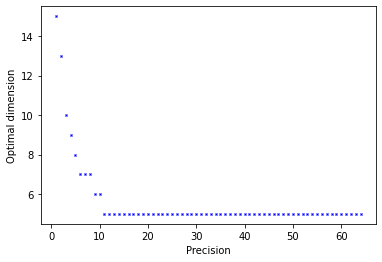

In [42]:
precision(zmdata_k5,4),GC_optk(zmdata_k5,precision(zmdata_k5,4)),GC_s(zmdata_k5)

(15, 10, None)

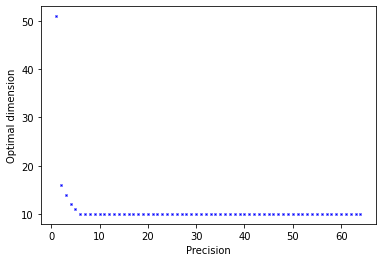

In [43]:
precision(zmdata_k10,4),GC_optk(zmdata_k10,precision(zmdata_k10,4)),GC_s(zmdata_k10)

(17, 30, None)

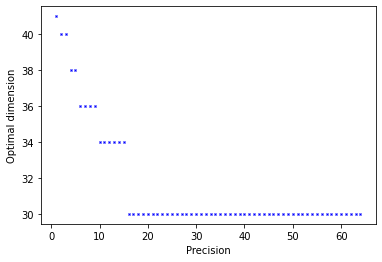

In [44]:
precision(zmdata_k30,4),GC_optk(zmdata_k30,precision(zmdata_k30,4)),GC_s(zmdata_k30)

(18, 6, None)

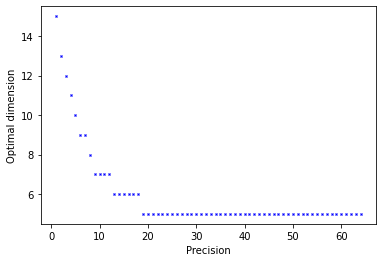

In [48]:
precision(my_data_test,4),GC_optk(my_data_test,precision(my_data_test,4)),GC_s(my_data_test)

**2. Scree plot and algorithms-comparing**

Minka Complexity 58
Tavory Complexity 5
Geometric Complexity 5


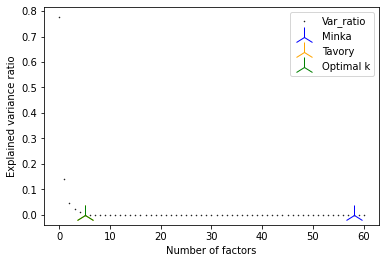

In [27]:
PCA_test(zmdata_k5,14)

Minka Complexity 55
Tavory Complexity 10
Geometric Complexity 10


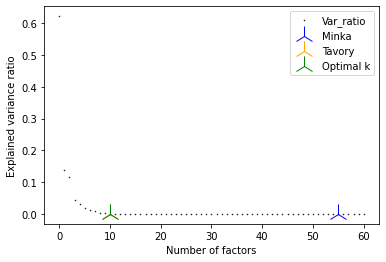

In [46]:
PCA_test(zmdata_k10,15)

Minka Complexity 50
Tavory Complexity 36
Geometric Complexity 30


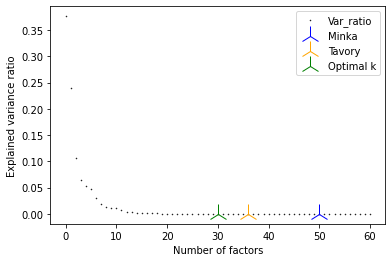

In [45]:
PCA_test(zmdata_k30,17)

Minka Complexity 5
Tavory Complexity 98
Geometric Complexity 5


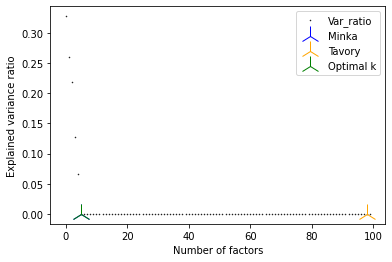

In [49]:
PCA_test(my_data_test,18)

<a id=sonar_data></a>
### Sonar-data  [$\tiny\triangle$](#test_data)

In [12]:
my_data_path='Data/sonar.all-data.csv'
my_data = genfromtxt('Data/sonar.all-data.csv', delimiter=',')

#removing class
mdata=my_data[:,:-1]

print('mdata:',mdata.shape, mdata.dtype)

mdata: (208, 60) float64


**1. GC optimal dimensionality reduction and precision**

(16, 21, None)

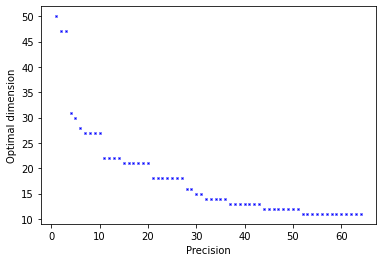

In [55]:
precision(my_data,4),GC_optk(my_data,precision(my_data,4)),GC_s(my_data)

**2. Scree plot and algorithms-comparing**

knee 9.0
Minka Complexity 57
Tavory Complexity 59
Geometric Complexity 28


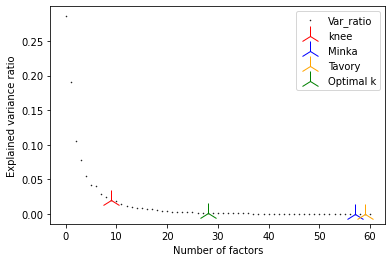

In [138]:
PCA_test(my_data,s=6)

In [137]:
GC_table(my_data,s=6,table=True)

         log(p)      model1    log(vol(s))    log(I(s))           GC
--  -----------  ----------  -------------  -----------  -----------
 1  1.3008e+06      1.74983        1.77182      1.42525  1.3008e+06
 2  1.29929e+06     5.25109        8.50068      7.35595  1.2993e+06
 3  1.2983e+06     10.505         20.0227      17.7921   1.29833e+06
 4  1.29744e+06    17.5127        36.214       32.7337   1.2975e+06
 5  1.29677e+06    26.2755        56.9754      52.1808   1.29685e+06
 6  1.29618e+06    36.7945        82.2238      76.1333   1.2963e+06
 7  1.2955e+06     49.071        111.888      104.591    1.29566e+06
 8  1.29497e+06    63.1061       145.906      137.555    1.29518e+06
 9  1.29447e+06    78.901        184.222      175.024    1.29473e+06
10  1.29399e+06    96.457        226.785      216.998    1.29432e+06
11  1.29351e+06   115.775        273.552      263.478    1.2939e+06
12  1.2931e+06    136.857        324.48       314.463    1.29356e+06
13  1.29274e+06   159.703        379.53

28

**3. Optimal dimensionality in function of data-length N**

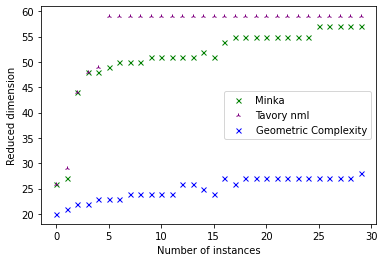

In [85]:
PCA_datalen(my_data,num=5,s=6)

**4. Optimal dimensionality in function of data-features d**

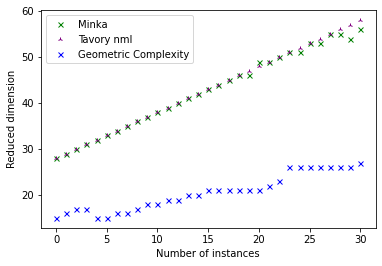

In [87]:
PCA_datafeat(my_data,s=6)

<a id=sparse_data></a>
### [Highly sparse data - source and description](https://archive.ics.uci.edu/ml/datasets/cnae-9)  [$\tiny\triangle$](#test_data)

In [13]:
#loading data
cnae_path='Data/CNAE-9.data'
cnae_data = genfromtxt(cnae_path, delimiter=',')
cn = open(cnae_path, "r")
#print(cn.read())
cn.close()

In [60]:
cnae_data=cnae_data[:,[i for i in range(1,cnae_data.shape[1])]] #removing class

In [61]:
cnae_data.shape

(1080, 856)

**1. GC optimal dimensionality reduction and precision**

In [65]:
precision(cnae_data,0)

1

In [66]:
GC_optk(cnae_data,1)

622

In [ ]:
#GC_s(cnae_data)

**2. Scree plot and algorithms-comparing**

Minka's built-in algorithm goes in overflow. I exclude it from the test.

knee 55.0
Tavory Complexity 624
Geometric Complexity 622


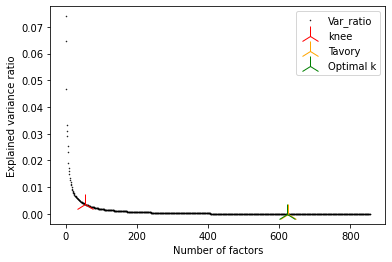

In [67]:
PCA_test(cnae_data,minka=0,s=1)

**3. Optimal dimensionality in function of data-length N**

In [69]:
shape(cnae_data)

(1080, 856)

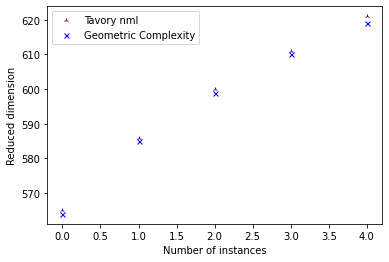

In [133]:
PCA_datalen(cnae_data,num=50,s=1,minka=0)

**4. Optimal dimensionality in function of data-features d**

In [ ]:
PCA_datafeat(cnae_data,num=20,s=1,minka=0)

<a id=drug_data></a>
### [Drug-data - source and description](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29) [$\tiny\triangle$](#test_data)
Just the first 13 features are not empty.

In [ ]:
#loading data
drug_path='Data/drug_consumption.data'
drug_data = genfromtxt(drug_path, delimiter=',')
dr=open(drug_path,'r')
#print(dr.read())
dr.close()

In [71]:
drug_data[:,1:14]

array([[ 0.49788,  0.48246, -0.05921, ..., -0.21712, -1.18084,      nan],
       [-0.07854, -0.48246,  1.98437, ..., -0.71126, -0.21575,      nan],
       [ 0.49788, -0.48246, -0.05921, ..., -1.37983,  0.40148,      nan],
       ...,
       [-0.07854,  0.48246,  0.45468, ...,  0.52975, -0.52593,      nan],
       [-0.95197,  0.48246, -0.61113, ...,  1.29221,  1.2247 ,      nan],
       [-0.95197, -0.48246, -0.61113, ...,  0.88113,  1.2247 ,      nan]])

In [72]:
drug_data=drug_data[:,1:13] #cutting class and missing entries

In [62]:
shape(drug_data)

(1885, 12)

**1. GC optimal dimensionality reduction and precision**

(22, 11, None)

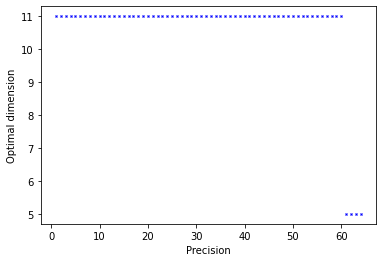

In [73]:
precision(drug_data,5),GC_optk(drug_data,precision(drug_data,5)),GC_s(drug_data)

**2. Scree plot and algorithms-comparing**

knee 3.0
Minka Complexity 11
Tavory Complexity 10
Geometric Complexity 11


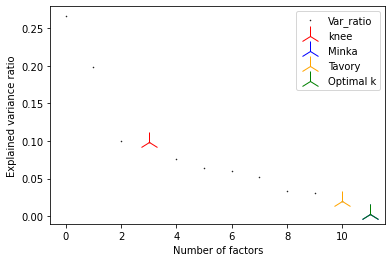

In [77]:
PCA_test(drug_data,s=22)

**3. Optimal dimensionality in function of data-length N**

In [78]:
shape(drug_data)

(1885, 12)

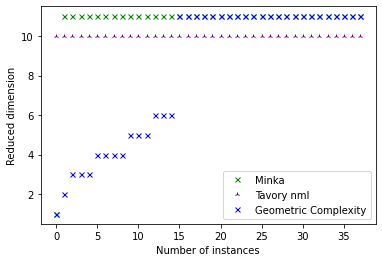

In [81]:
PCA_datalen(drug_data,num=50,s=22)

**4. Optimal dimensionality in function of data-features d**

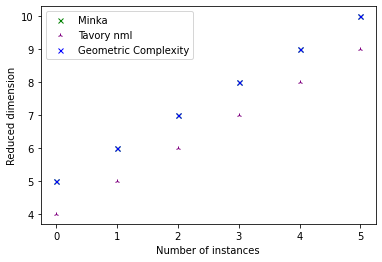

In [84]:
PCA_datafeat(drug_data,s=22)

<a id=music_data></a>
### [Music data - source and description](https://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music) [$\tiny\triangle$](#test_data)

In [ ]:
#loading data
music_path='Data/default_features_1059_tracks.txt'
music_data = genfromtxt(music_path, delimiter=',')
ms=open(music_path,'r')
#print(ms.read())
ms.close()

In [89]:
shape(music_data)

(1059, 70)

In [90]:
music_datacut=music_data[:,:68]#last two features have very different precision 

**1. GC optimal dimensionality reduction and precision**

(27, 21, None)

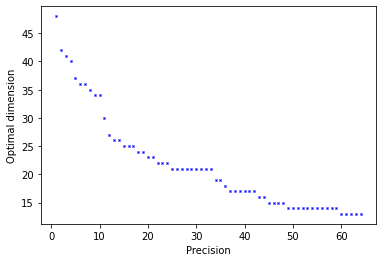

In [93]:
precision(music_datacut,6,b=1),GC_optk(music_datacut,precision(music_datacut,6,b=1)),GC_s(music_datacut)

**2. Scree plot and algorithms-comparing**

knee 10.0
Minka Complexity 67
Tavory Complexity 66
Geometric Complexity 21


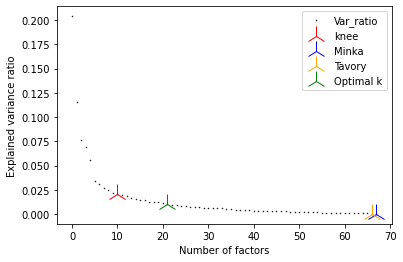

In [94]:
PCA_test(music_datacut,s=27)

**3. Optimal dimensionality in function of data-length N**

In [95]:
shape(music_datacut)

(1059, 68)

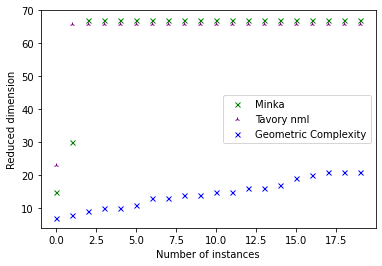

In [97]:
PCA_datalen(music_datacut,num=50,s=27)

**4. Optimal dimensionality in function of data-features d**

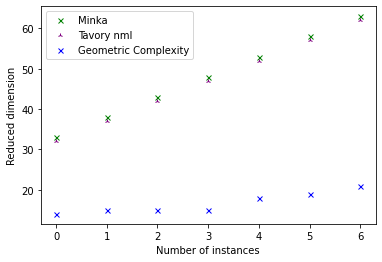

In [99]:
PCA_datafeat(music_datacut,num=5,s=27)

<font color=blue> We are now going to analyze the same dataset including the two features with different precision and using the function ```data_int()``` for pre-processing the data and determining the parameter s.</font>

I.e. we rescale the covariance matrix s.t. every features is written as multiple of a fundamental precision -- 1e6 for the first 68 features, 1e2 for the last 2. We are then going to analyse the resulting integers-matrix. We remark that the optimal-dimensionalities computed via Tavory and Minka algorithms o the original matrix and on the rescaled one are equivalent.

In [106]:
music_data = genfromtxt(music_path, delimiter=',')

music_dataint=music_data[:]
music_dataint[:,:68]=music_dataint[:,:68]*1e6
music_dataint[:,69:]=music_dataint[:,69:]*1e2
music_dataint

music_dataint=data_int(music_dataint,1)

**1. GC optimal dimensionality reduction and precision**

(27, 22, None)

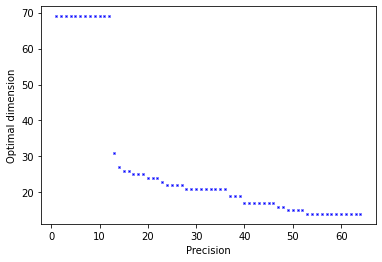

In [107]:
precision(music_dataint,0,b=1),GC_optk(music_dataint,precision(music_dataint,0,b=1)),GC_s(music_dataint)

**2. Scree plot and algorithms-comparing**

knee 10.0
Minka Complexity 69
Tavory Complexity 68
Geometric Complexity 22


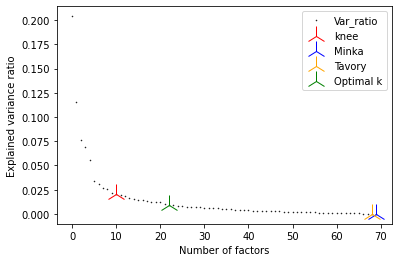

In [108]:
PCA_test(music_dataint,s=27)

**3. Optimal dimensionality in function of data-length N**

In [110]:
shape(music_dataint)

(1059, 70)

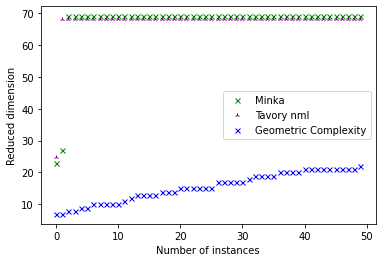

In [111]:
PCA_datalen(music_dataint,num=20,s=27)

**4. Optimal dimensionality in function of data-features d**

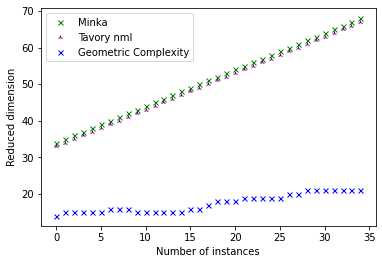

In [113]:
PCA_datafeat(music_dataint,s=27)

<a id=ceramic_data></a>
### [Ceramic composition data - source and description](https://archive.ics.uci.edu/ml/datasets/Chemical+Composition+of+Ceramic+Samples) [$\tiny\triangle$](#test_data)

In [ ]:
#loading data
ceramic_path='Data/Chemical_Composion_Ceramic.csv'
ceramic_data = genfromtxt(ceramic_path, delimiter=',')
cer=open(ceramic_path,'r')
#print(cer.read())
cer.close()

**Data pre-processing**

In [115]:
#add ppm (*1e-4) from MnO on
#separating body-glaze in two distinct dataset
#removing classes

In [116]:
ceramic_dataint=ceramic_data[:]#dataset cloning
ceramic_dataint=ceramic_dataint[1:]#reoving labelling
for i in range(2,10):
    ceramic_dataint[:,i]=ceramic_dataint[:,i]*1e2
ceramic_dataint_body=ceramic_dataint[:44,2:]
ceramic_dataint_body=data_int(ceramic_dataint_body,1)
ceramic_dataint_glaze=ceramic_dataint[44:,2:]
ceramic_dataint_glaze=data_int(ceramic_dataint_glaze,1)

**1. GC optimal dimensionality reduction and precision**

(10, 4, None)

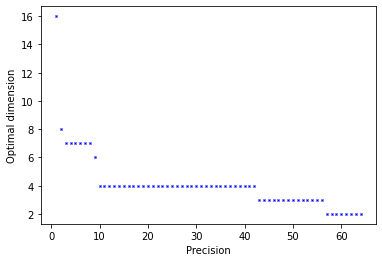

In [124]:
precision(ceramic_dataint_body,0),GC_optk(ceramic_dataint_body,precision(ceramic_dataint_body,0)),GC_s(ceramic_dataint_body)

(11, 6, None)

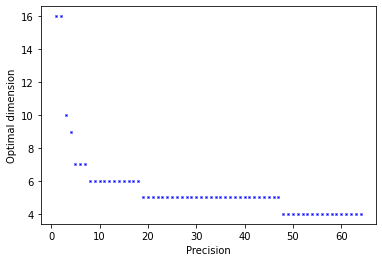

In [122]:
precision(ceramic_dataint_glaze,0),GC_optk(ceramic_dataint_glaze,precision(ceramic_dataint_glaze,0)),GC_s(ceramic_dataint_glaze)

**2. Scree plot and algorithms-comparing**

knee 2.0
Minka Complexity 16
Tavory Complexity 15
Geometric Complexity 7


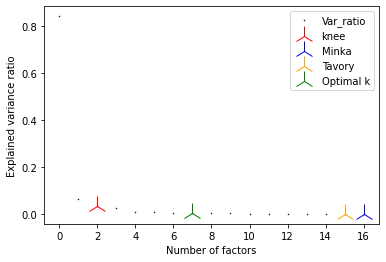

In [125]:
PCA_test(ceramic_dataint_body,s=8)

knee 3.0
Minka Complexity 16
Tavory Complexity 15
Geometric Complexity 6


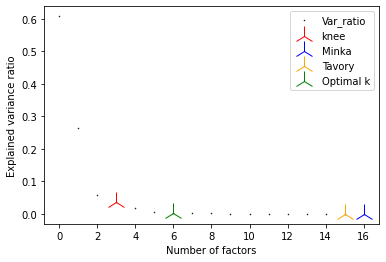

In [123]:
PCA_test(ceramic_dataint_glaze,s=11)

**3. Optimal dimensionality in function of data-length N**

In [126]:
shape(ceramic_dataint_body),shape(ceramic_dataint_glaze)

((44, 17), (44, 17))

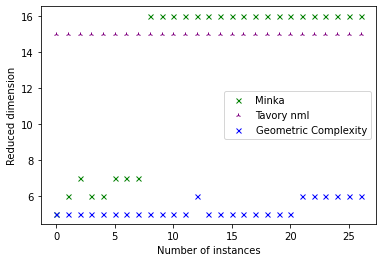

In [127]:
PCA_datalen(ceramic_dataint_body,s=8)

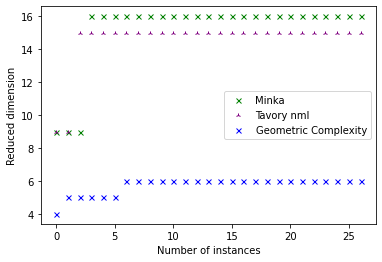

In [128]:
PCA_datalen(ceramic_dataint_glaze,s=11)

**4. Optimal dimensionality in function of data-features d**

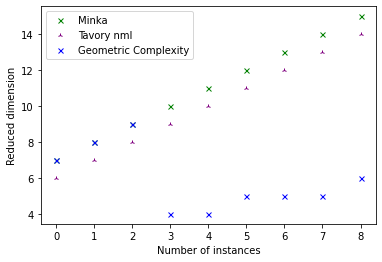

In [129]:
PCA_datafeat(ceramic_dataint_body,s=8)

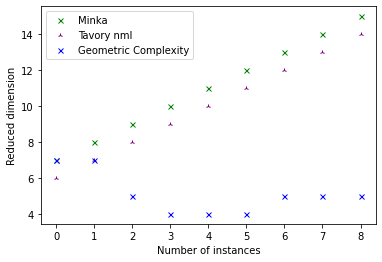

In [130]:
PCA_datafeat(ceramic_dataint_glaze,s=11)

<a id=conclusion></a>
# Comments and future work [$\diamond$](#TC)
<hr>
<hr>
- The *Geometric Complexity algorithm* (GC-alg.), in general underestimates the optimal dimensionality reduction with respect to the two existing algorithms of Tavory and Minka. Indeed, in the GC_alg. the model length that plays an important role in the two-part-code optimisation. When the model is more complex -- high data-precision for example, i.e. high s -- more the model-code-legth weighs in the total code-length. Indeed in general Minka's and/or Tavory's results are recovered for low s by the GC-alg.

- We gave and euristic procedure for determining the s-parameter, which deserves furter tests. For example, by using the ```data_Tavory()``` and changing the noise-variance.

- The GC-algorithm has a slower convergence to a 'stable' value for the optimal-dimensionality in function of the dataset-dimesion as seen in the plots (3) and (4), result that justifies the relevant underestimation obtained for small dataset. The algorithm deserves further tests on higher-dimension datasets.

<a id=appendix></a>
# <font color=grey> Appendix </font> [$\diamond$](#TC)

## Data-processing routine

**1. GC optimal dimensionality reduction and precision**

In [ ]:
precision(data,sign),GC_optk(data,precision(data,sign)),GC_s(data)

**2. Scree plot and algorithms-comparing**

In [ ]:
PCA_test(data,s=)

**3. Optimal dimensionality in function of data-length N**

In [ ]:
shape(data)

In [ ]:
PCA_datalen(data,num=,s=)

**4. Optimal dimensionality in function of data-features d**

In [ ]:
PCA_datafeat(data,num=,s=)

## Plus-minus test /24N test

In [33]:
def GC_optk_test(data,s=64,b=0):
    
    def sum_logf(length):
        '''Return a list of given length whose entries are:
           list[i-1]=sum_a=1^i(np.log(a)+np.log(gamma(a/2)))'''
        sumlog_vec=[]
        sumlog1=0
        for a in range(1,length): 
            sumlog1=sumlog1+np.log(a)+lgm(a/2)
            sumlog_vec.append(sumlog1)
        return sumlog_vec
    
    def log_gauss(N,d,k,lambdas,Sw):
    
        'lambdas=pca.explained_variance_'
        #k=k-1
        if k==d:
            lambda_bar=1
        else:
            lambda_bar=sum(lambdas[k:])/(d-k)
        #print('k:',k,'lambda_bar',lambda_bar)   
        Q=np.diag([1/eig for eig in lambdas[:k]]+[1/lambda_bar for i in range(k,d)])
        r=d*np.log(2*np.pi)
        r=r+sum(np.log(lambdas[:k])) #kth-eigen included
        r=r+(d-k)*np.log(lambda_bar)
        r=r+np.trace(Q@Sw)
        return r*N/2
    
    zm_data=zeromean(data)
    pca = PCA().fit(zm_data)
    dimrange=pca.components_.shape[0] #number of features
    N=zm_data.shape[0] #number of instances
    if (dimrange != zm_data.shape[1]):
            print("attributes have linear dependencies, ther is a non-trivial kernel in the covariance matrix")
            print("Solution: remove dependent variables eg: averages over the variables")
            return "error";
    rotdata=changebasis(zm_data,pca.components_)
    optd=-1;
    optscore=np.Infinity
    S=np.matmul(rotdata.T,rotdata)
    sumlog_vec=sum_logf(dimrange+1)
    for m in range(1,dimrange+1):
        r=log_gauss(N,dimrange,m, pca.explained_variance_,S)
        r=r+m*(m+1)/4*np.log(N/(2*np.pi)) #a
        r=r+(-1)*b*m*(m+2)*(m-1)/(24*N) #b
        r=r-m/2*np.log(2)+m*(m+1)/4*np.log(np.pi) #c
        sumlog=sumlog_vec[m-1]
        r=r-sumlog
        r=r+m*np.log(s*np.log(2))+(2*s+1)*m*(m-1)/4*np.log(2) 
        if(r<optscore):
            optd=m;  
            optscore=r
    
    return optd

In [76]:
def PCA_datalen_test(data, num=1, s=64, vec=0, Nmax=0):
    
    '''INPUT data-matrix Nxd, integer num, integer s
    OUTPUT plot of the optimal dimensionality reduction obtained with the three algorithms -- Minka, Tavory-NML,
    Geometric Complexity -- in function of the dimension of the dataset. 
    Options The integer num indicate the interval between two different evaluations and s is the precision parameter
    for the Geometric Complexity algorithm.'''
    
    zmdata=zeromean(data)
    data_pca=PCA().fit(X=data)
    gc_k=[]
    gc_k1=[]
    if Nmax==0:
        Nmax=shape(zmdata)[0]
    for i in range(shape(zmdata)[1]+1,Nmax+1,num):
    #for i in range(shape(zmdata)[1]+1,shape(zmdata)[0]+1,num):
        gc=GC_optk_test(zmdata[:i],s)
        gc_k.append(gc)
        gc1=GC_optk_test(zmdata[:i],s,b=1)
        gc_k1.append(gc1)
    plot(gc_k, 'x', markersize=5,label='GC plus',color="blue")
    plot(gc_k1, '.', markersize=5,label='GC minus',color="red")

    legend();
    xlabel('Number of instances').set_color('black');
    ylabel('Reduced dimension').set_color('black');
    if vec==1:
        return gc_k,gc_k1

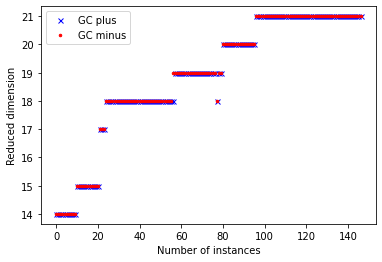

In [77]:
PCA_datalen_test(my_data, num=1, s=15, vec=0)

In [51]:
shape(my_data)

(208, 61)

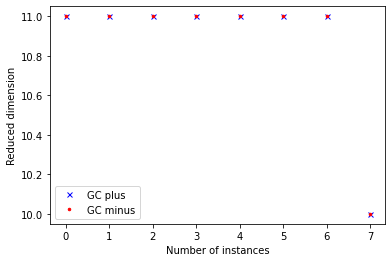

In [78]:
PCA_datalen_test(my_data, num=1, s=20, vec=0, Nmax=69)

<a id=list_functions></a>
# <font color=grey> List of functions</font> [$\diamond$](#TC)

- [```changebasis(data, components)```](#data_matrix_rot)
- [```data_int(data,order)```](#data_precision)
- [```data_Tavory(data,k,tau)```](#partial_dataset)
- [```GC_optk(data,s=64)```](#GC_optk)
- [```GC_s(data)```](#GC_s)
- [```GC_table(data,s=64,table=False)```](#GC_table)
- [```Minka_optk(data)```](#Minka_f)
- [```nml_optk(data)```](#Tavory)
- [```PCA_datafeat(data, num=1, minka=1, tavory=1, GC=1, s=64)```](#PCA_datafeat)
- [```PCA_datalen(data, num=1, minka=1, tavory=1, GC=1, s=64)```](#PCA_datalen)
- [```PCA_test(data, knee=1, rounds=10, minka=1, tavory=1, GC=1, s=64)```](#PCA_test)
- [```precision(data,sign_digits,b=0)```](#data_precision)
- [```zeromean(data)```](#zero_mean)



In [34]:
?PCA_test

<a id=References></a>
# <font color=grey> References</font> [$\diamond$](#TC)

Data repository [https://archive.ics.uci.edu/ml/index.php](https://archive.ics.uci.edu/ml/index.php)

<a id=Minka></a>[[Minka2000]](https://papers.nips.cc/paper/2000/file/7503cfacd12053d309b6bed5c89de212-Paper.pdf) Minka, Thomas P. "Automatic choice of dimensionality for PCA." Nips. Vol. 13. 2000.

<a id=kneedle>[Satopaa2011]</a> Ville Satopaa, Jeannie R. Albrecht, David E. Irwin, and Barath Raghavan. Finding
a "kneedle" in a haystack: Detecting knee points in system behavior. In 31st IEEE
International Conference on Distributed Computing Systems Workshops (ICDCS
2011 Workshops), 20-24 June 2011, Minneapolis, Minnesota, USA, pages 166{171,
2011.

<a id=tavory></a>[[Tavory2019]](https://arxiv.org/abs/1901.00059) Tavory, Ami. Determining Principal Component Cardinality Through the Principle of Minimum Description Length. International Conference on Machine Learning, Optimization, and Data Science. Springer, Cham, 2019.

<a id=Paulo></a>[[Mera&al.2020]](https://dev.arxiv.org/abs/2007.02904?context=math) Mera, Bruno, Mateus, Paulo, and Carvalho, Alexandra M.. "On the minmax regret for statistical manifolds: the role of curvature." arXiv preprint arXiv:2007.02904 (2020).